Part 2: Predicting precision: straight sum, linearly trained, specifically trained.

Setup:

In [16]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import os
import pickle
import demixing as dm
from demixing import MLP, HiddenLayer

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
eps = np.finfo(np.float64).eps
sigtc_sq = float(10**2)

Train network:

In [2]:
nns = {}
for i in range(400):
    file_name = 'output_nn_tests_2/nn_tests_2_' + str(i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_mse, _, _ = pickle.load(pkl_file)
        nns[i] = (nn, nnx, valid_mse)

In [3]:
posts = {}
testsets = {}
for s_i in range(31):
    file_name = 'output_post_2/post_2_' + str(s_i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        p, r, c, delta_s = pickle.load(pkl_file)
        posts[delta_s] = p
        testsets[delta_s] = r

In [117]:
pkl_file = open('readout.pkl', 'wb')
pickle.dump((posts, testsets), pkl_file)
pkl_file.close()

Readout of posterior:

In [101]:
nn, nnx, valid_mse = nns[43]
x = []
y = []
for s_i in range(31):
    x.append(dm.get_hu_responses(testsets[s_i], nn))
    y.append(np.array((1/posts[s_i]['var_s1'], 1/posts[s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
inds = range(len(x))
np.random.shuffle(inds)
x_shuf = x[inds]
y_shuf = y[inds]
validset = x_shuf[0:2000], y_shuf[0:2000]
trainset = x_shuf[2000:], y_shuf[2000:]

In [109]:
nn_post, nnx_post, valid_mse_post = dm.train_nn(trainset, valid_dataset=validset, n_in=20, learning_rate=0.0001, n_epochs=100, linear=True, rho=.9, mu=.99, nesterov=True)

[[ 1.          0.83259099]
 [ 0.83259099  1.        ]]


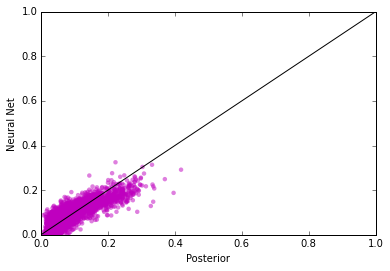

In [110]:
hus, vpost = validset
nn_posts1 = dm.get_hu_responses(hus, nn_post)
vp = np.concatenate((vpost.T[0], vpost.T[1]))
np1 = np.concatenate((nn_posts1.T[0], nn_posts1.T[1]))
plt.scatter(vp, np1, c='m', alpha=.5, edgecolor="None")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
plt.plot(range(2), c='k')
print np.corrcoef(vp, np1)

[[ 1.         -0.09850753]
 [-0.09850753  1.        ]]


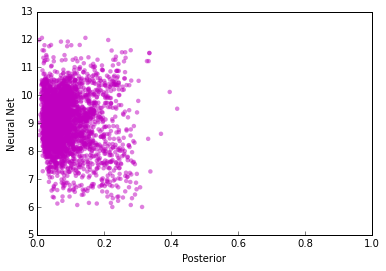

In [104]:
hus, vpost = validset
nn_posts1 = np.sum(hus, axis=1)
vp = np.concatenate((vpost.T[0], vpost.T[1]))
np1 = np.concatenate((nn_posts1, nn_posts1))
plt.scatter(vp, np1, c='m', alpha=.5, edgecolor="None")
#plt.scatter(vp[1], nn_posts1)
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
ax = plt.axes()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.corrcoef(vp, np1)

In [118]:
x = []
y = []
for s_i in range(31):
    x.append(testsets[s_i])
    y.append(np.array((1/posts[s_i]['var_s1'], 1/posts[s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
x_shuf = x[inds]
validset2 = x_shuf[0:2000], y_shuf[0:2000]
trainset2 = x_shuf[2000:], y_shuf[2000:]

In [111]:
nn_post2, nnx_post2, valid_mse_post2 = dm.train_nn(trainset2, valid_dataset=validset2, learning_rate=0.0001, mult_ys=False, n_epochs=100, rho=.9, mu=.99, nesterov=True)

[[ 1.          0.91955554]
 [ 0.91955554  1.        ]]


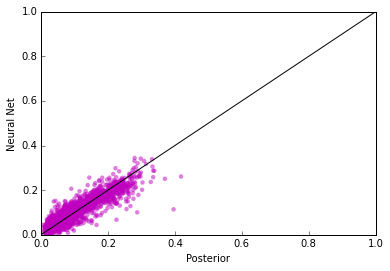

In [112]:
_, vpost2 = validset2
nn_posts2, _ = dm.test_nn(nn_post2, nnx_post2, validset2)
vp = np.concatenate((vpost2.T[0], vpost2.T[1]))
np2 = np.concatenate((nn_posts2.T[0], nn_posts2.T[1]))
plt.scatter(vp, np2, c='m', alpha=.5, edgecolor="None")
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(range(2), c='k')
ax = plt.axes()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.corrcoef(vp, np2)

In [120]:
print validset, validset2

(array([[-0.        , -0.        ,  0.63171638, ...,  1.826828  ,
         0.99588364, -0.        ],
       [ 0.09476627,  0.04910473,  1.09147353, ...,  1.65051163,
         0.70484941, -0.        ],
       [ 0.38273916,  0.18356156,  0.82254865, ...,  1.45062713,
         0.87570502, -0.        ],
       ..., 
       [-0.        ,  0.58836964,  0.63773847, ...,  1.50283921,
         0.94249828, -0.        ],
       [ 0.34940479,  0.44082257,  0.5877673 , ...,  1.51846834,
         0.74102743, -0.        ],
       [-0.        , -0.        ,  0.66344481, ...,  1.67928723,
         0.86643886, -0.        ]]), array([[ 0.16134395,  0.06993575],
       [ 0.05996256,  0.06750911],
       [ 0.05437135,  0.09995536],
       ..., 
       [ 0.15817453,  0.03247025],
       [ 0.04751606,  0.04081353],
       [ 0.03188693,  0.04782752]])) (array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0., 

In [121]:
pkl_file = open('readout_1.pkl', 'rb')
rd = pickle.load(pkl_file)
print rd

(array([ 0.06187915,  0.07298851,  0.08987438, ...,  0.21521258,
        0.09715683,  0.11133069]), array([[ 1.        ,  0.82077972],
       [ 0.82077972,  1.        ]]), array([ 0.05077497,  0.07923475,  0.07991808, ...,  0.24504019,
        0.07255347,  0.10325793]), array([[ 1.        ,  0.91352552],
       [ 0.91352552,  1.        ]]), array([ 9.56854349,  9.28214736,  9.31757406, ...,  7.75922712,
        8.37729104,  8.54751206]), array([[ 1.        ,  0.04941512],
       [ 0.04941512,  1.        ]]), array([ 0.00769277,  0.00448455,  0.00322728,  0.0029514 ,  0.00279151,
        0.00268122,  0.00260102,  0.00254073,  0.0024941 ,  0.00245722,
        0.00242774,  0.00240353,  0.00238337,  0.0023665 ,  0.00235229,
        0.00233965,  0.00232894,  0.00231958,  0.00231145,  0.00230432,
        0.00229789,  0.00229241,  0.00228738,  0.00228288,  0.00227861,
        0.00227485,  0.00227156,  0.00226863,  0.00226595,  0.00226362,
        0.00226143,  0.00225944,  0.00225763,  0.00225